## I SPY: ETF Price Predictions
Author: Wei Alexander Xin

## Setup

In [540]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import yfinance as yf
import quandl
from alpha_vantage.timeseries import TimeSeries
import pandas_market_calendars as mcal
import mplfinance as mpl
import pmdarima as pm

import sys, os
code_path = '/code'
auth_path = '/auth'
if '..' + code_path not in sys.path:
    sys.path.insert(0, '..' + code_path)
if '..' + auth_path not in sys.path:
    sys.path.insert(0, '..' + auth_path)
current_path = os.getcwd()

import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

%matplotlib inline
font = {'size'   : 12}
matplotlib.rc('font', **font)

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',50)

from code.functions import *
from code.Pmdarima_Model import Pmdarima_Model
from code.Gridsearch_Calc_Profit import Gridsearch_Calc_Profit
from code.Model_Historical_Simuluation import Model_Historical_Simuluation

from auth.keys import client_id, secret_key, av_key, consumer_key

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Intro and Summary of EDA

The SPY - [SPDR® S&P 500 ETF](https://www.ssga.com/us/en/institutional/etfs/funds/spdr-sp-500-etf-trust-spy) - is the most well-known and liquid index ETF. Sometimes loving referred to as the "spider", one might trade "the spiders".  

In this project, we will delve into the characteristics of this time series, attempt to model as much as we can, pull in various exogenous features such as SPY Futures prices, Treasury Bond yields, and determine our best model by running a .  

To further validate our model's performance, we'll perform historical simulations on our model outputs, treating historical prices that go above or below our predictions as sell or buy signals, and calculate the total profit in a given time frame. This will be compared against the "buy and hold" strategy.

Lastly, we'll generate forecasts 52 days forward. Retail traders don't have access to the sophisticated trading models used by financiers, so this is an attempt to help level the playing field using freely available tools. Based on these outputs, we will attempt to "beat the stock market".

Note this the author of this project is not an financial advisor, and this is not financial advice.

## Get NYSE Trading Days Calendar

Using [Pandas Market Calendars](https://pypi.org/project/pandas-market-calendars), we can define a custom calendar offset in Pandas to only include valid trading days. This will allow us to use a frequency calculation of CustomBusinessDay (defined here as `CBD`) in our modeling, as well as allow us to find and generate dates that are actual trading days. More info on trading days are [here](https://www.nyse.com/markets/hours-calendars).

In [11]:
NYSE = mcal.get_calendar('NYSE')
CBD = NYSE.holidays()

## Load Data

We will data from the past 3, 5, 10, and 20 years for our endogenous variable, SPY daily closing price, as well as several exogenous variables.  
The SPY was launched January 29, 1993, however not all data sets go back that far, and time series must match in length.  
We've checked for NaN values in our EDA/Modeling notebooks.

For the purposes of this notebook, we will focus primarily on the 10 year slice.

We also looked at sampling frequencies of 1 hour as well as 1 minute, however this causes the data set to grow too large to be computationally effective. For time frames, the trend was not strong enough and the volatiltiy too great for meaningful analysis.

In [35]:
years = [3, 5, 10, 20]

### Endogenous Variable

SPY Price Data  
We download four data sets representing prices, using [yfinance](https://pypi.org/project/yfinance), for the past 3, 5, 10, and 20 years and save them to file. Another function loads the files as DataFrames and sets frequency to `CBD`.  Finally, we break out the Open, High, Low, Close, Adjusted Close, and Volume data.

In [321]:
spy_df_10Y

,open,high,low,close,adj_close,volume
date,,,,,,
2011-05-02,137.070007,137.179993,135.949997,136.220001,111.753159,126278700
2011-05-03,135.960007,136.190002,135.039993,135.729996,111.351181,138375000
2011-05-04,135.669998,135.729996,134.229996,134.830002,110.612801,182678500
2011-05-05,134.080002,134.949997,133.020004,133.610001,109.611984,226900000
2011-05-06,134.940002,135.630005,133.679993,134.199997,110.096001,222787200
...,...,...,...,...,...,...
2021-05-06,415.829987,419.209991,413.679993,419.070007,419.070007,74321400
2021-05-07,419.890015,422.820007,419.160004,422.119995,422.119995,67680100
2021-05-10,422.500000,422.739990,417.809998,417.940002,417.940002,81852400


In [ ]:
symbol = 'SPY'
get_yf_time_series(yf, years, symbol, freq=CBD)
spy_df_3Y = load_yf_time_series(yf, 3, symbol, freq=CBD)
spy_df_5Y = load_yf_time_series(yf, 5, symbol, freq=CBD)
spy_df_10Y = load_yf_time_series(yf, 10, symbol, freq=CBD)
spy_df_20Y = load_yf_time_series(yf, 20, symbol, freq=CBD)

In [ ]:
df_10Y_close = spy_df_10Y.close     # our endogenous variable

### Exogenous Variables - Price Data

The rest of the SPY OHLC can be extracted from the same data set.

In [235]:
df_10Y_vol = spy_df_10Y.volume
df_10Y_open = spy_df_10Y.open
df_10Y_high = spy_df_10Y.high
df_10Y_low = spy_df_10Y.low
df_10Y_a_close = spy_df_10Y.adj_close

SPY [Futures](https://www.investopedia.com/terms/f/futures.asp) ([E-mini S&P 500](https://www.cmegroup.com/trading/equity-index/us-index/e-mini-sandp500.html)) Price Data  
This will load four data sets as above. This symbol only goes as far back as September 18, 2000, which is why we chose 20Y for the last data set for SPY instead of the full 28Y.  This data requires some interpolation.

We'll focus on the 'close' column only.  Also, to avoid column name conflict with SPY 'close', we will add 'f_' to the column name.

In [ ]:
f_symbol = 'ES=F'
get_yf_time_series(yf, years, f_symbol, freq=CBD)
spy_f_df_3Y = load_yf_time_series(yf, 3, f_symbol, freq=CBD, impute=True)
spy_f_df_5Y = load_yf_time_series(yf, 5, f_symbol, freq=CBD, impute=True)
spy_f_df_10Y = load_yf_time_series(yf, 10, f_symbol, freq=CBD, impute=True)
spy_f_df_20Y = load_yf_time_series(yf, 20, f_symbol, freq=CBD, impute=True)

In [582]:
df_f_10Y_close = spy_f_df_10Y.close
df_f_10Y_close.name = 'f_' + df_f_10Y_close.name

### Exogenous Variables - Interest Rates

A description of a list of interest rates can be found via the [Federal Reserve](https://www.federalreserve.gov/releases/h15/).

[US Treasury Bond Yield Data](https://www.treasurydirect.gov/indiv/products/prod_tnotes_glance.htm)  
We will source these from [Quandl](https://www.quandl.com/tools/python). We slice the data set to match the date indices of the SPY price data set.  
This data set contains yields for all the US Treasury Bonds; we are primarily interested in the 10 YR Note, as that is the standard for which the markets is evaluated.  This data requires a little interpolation.

In [146]:
tsy_symbol = 'USTREASURY/YIELD'
tsy_3Y_df = get_quandl_time_series(quandl, 3, tsy_symbol, CBD)
tsy_5Y_df = get_quandl_time_series(quandl, 5, tsy_symbol, CBD)
tsy_10Y_df = get_quandl_time_series(quandl, 10, tsy_symbol, CBD)
tsy_20Y_df = get_quandl_time_series(quandl, 20, tsy_symbol, CBD)

Functions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


Federal Funds Target Rate Data  
The [federal funds effective rate](https://fred.stlouisfed.org/series/FEDFUNDS) is the average rate that federal funds are actually traded, which is determined by the market.  This data is only available from 2008, so we only produce 3 data slices.
Same source as above.  
Note that this data is sometimes published to Quandl with a day or more delay - if so, we may need to drop the last date for the other DataFrames. Alternatively, the most up to date value can be brought in from the FRED site above.

In [324]:
fed_fund_target = 'FRED/DFEDTARU'
fed_t_3Y_df = get_quandl_time_series(quandl, 3, fed_fund_target, CBD)
fed_t_5Y_df = get_quandl_time_series(quandl, 5, fed_fund_target, CBD)
fed_t_10Y_df = get_quandl_time_series(quandl, 10, fed_fund_target, CBD)
fed_t_20Y_df = get_quandl_time_series(quandl, 20, fed_fund_target, CBD)

Federal Funds Effective Rate Data  
The [federal funds target rate](https://fred.stlouisfed.org/series/DFEDTARU) is the interest rate at which institutions trade federal funds overnight. The target rate is set by the Federal Open Market Committee ([FOMC](https://www.federalreserve.gov/monetarypolicy/fomc.htm)) at their meetings held 8 times a year.  We are looking at the upper limit of this target.
Same source as above, and same issue may exist with the data delay.

In [338]:
fed_funds_symbol = 'FRED/DFF'
fed_3Y_df = get_quandl_time_series(quandl, 3, fed_funds_symbol, CBD)
fed_5Y_df = get_quandl_time_series(quandl, 5, fed_funds_symbol, CBD)
fed_10Y_df = get_quandl_time_series(quandl, 10, fed_funds_symbol, CBD)
fed_20Y_df = get_quandl_time_series(quandl, 20, fed_funds_symbol, CBD)

In [500]:
fed_10Y_df[pd.to_datetime('2021-05-12')] = 0.06

### Exogenous Variable - Options Expiry

We will engineer one feature - `is_option_expiry`.  
[Options](https://www.investopedia.com/terms/o/option.asp) on SPY expire on [Mondays, Wednesdays, and Fridays](https://www.nasdaq.com/market-activity/funds-and-etfs/spy/option-chain), but these are moved to account for holidays. Typically volatility is higher on option expiry dates.


This data does not need to be modeled, because we can extend the date as far into the future as needed.

In [138]:
opt_exp_3Y_df = create_option_expiry_df(date_index=spy_df_3Y.index, func='historical', freq=CBD)
opt_exp_5Y_df = create_option_expiry_df(date_index=spy_df_5Y.index, func='historical', freq=CBD)
opt_exp_10Y_df = create_option_expiry_df(date_index=spy_df_10Y.index, func='historical', freq=CBD)
opt_exp_20Y_df = create_option_expiry_df(date_index=spy_df_20Y.index, func='historical', freq=CBD)

## Data Exploration

## Visualization

Plot times series for SPY, SPY Futures, Treasury 10Y Note, and Fed Funds Rate.  
Note that the SPY Futures tracks the SPY (which in turns tracks the S&P 500) fairly closely.

Functions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


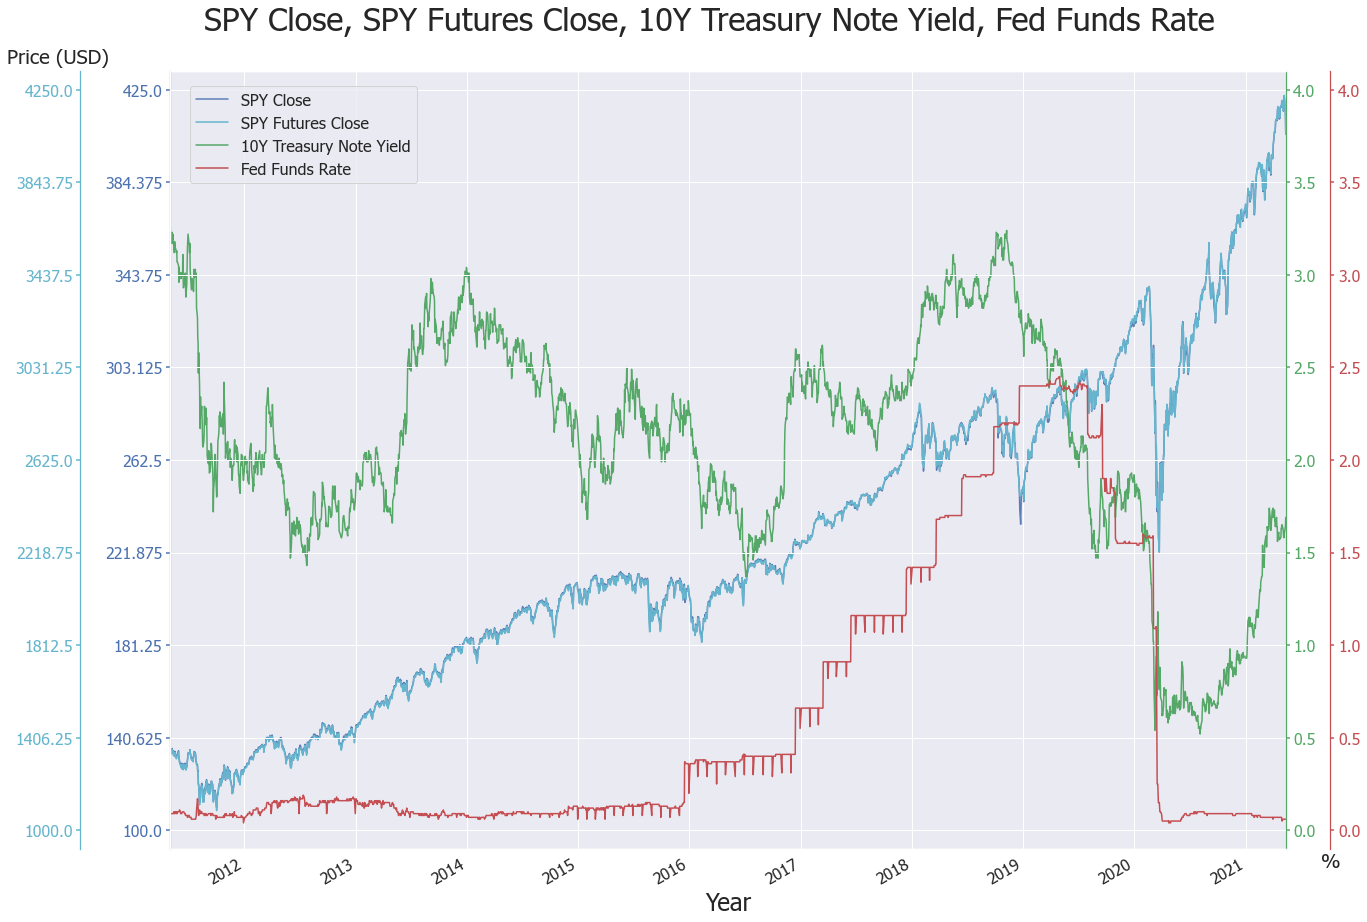

In [62]:
data = [df_10Y_close, df_f_10Y_close, tsy_10Y_df, fed_10Y_df]
plot_spy_fut_tsy_funds_time_series(data)

We can also plot SPY using [candlesticks](https://www.investopedia.com/terms/c/candlestick.asp) as the indicator of movement over each period of time.  This plot uses the [mplfinance](https://pypi.org/project/mpl-finance/) library.

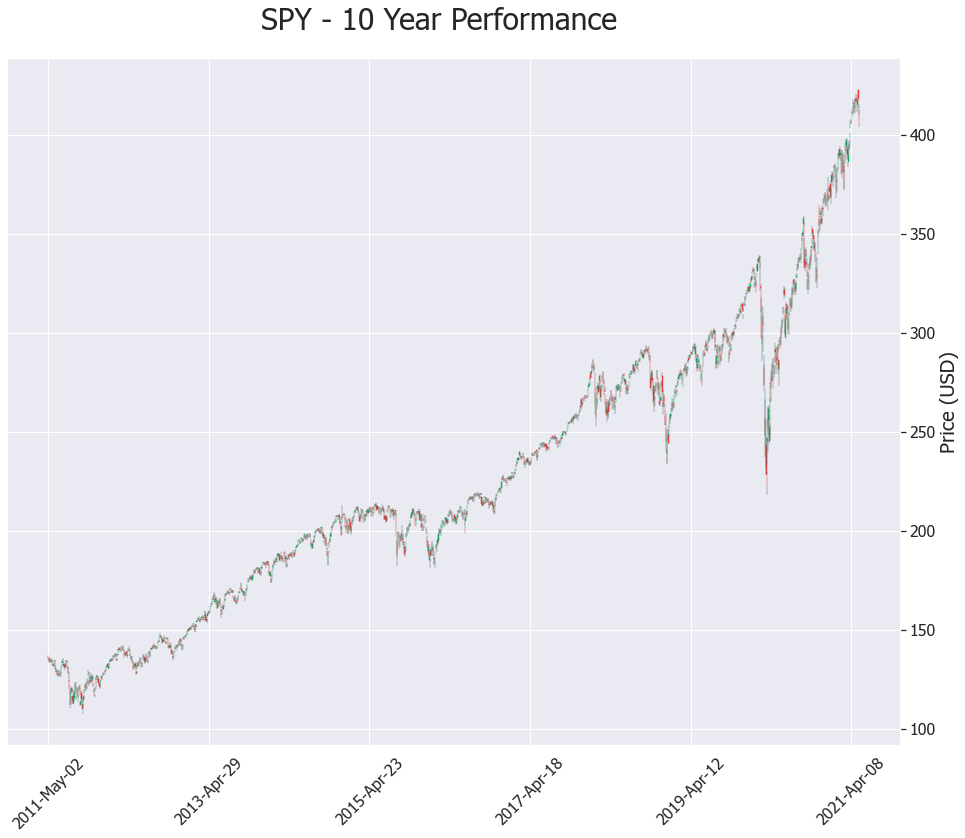

In [98]:
plot_spy_fin(spy_df_10Y);

# Data Prep

## Test Stationarity

Test stationarity for our data, undifferenced. We see that the p-value is above 0.05, meaning this does not pass the test.

In [140]:
test_stationarity(df_10Y_close)

Test Statistic                    0.828780
p-value                           0.992087
#Lags Used                       27.000000
Number of Observations Used    2497.000000
Critical Value (1%)              -3.432972
Critical Value (5%)              -2.862698
Critical Value (10%)             -2.567387
dtype: float64


Test stationarity for our endogenous data, differenced once. We see that the p-value is now miniscule, which passes the test.

In [141]:
test_stationarity(df_10Y_close, 1)

Test Statistic                -1.071557e+01
p-value                        3.248184e-19
#Lags Used                     2.600000e+01
Number of Observations Used    2.497000e+03
Critical Value (1%)           -3.432972e+00
Critical Value (5%)           -2.862698e+00
Critical Value (10%)          -2.567387e+00
dtype: float64


Testing stationarity for our various other exogenous variables all show that once differencing is needed.

## Plot ACF and PACF

Plot Partial Autocorrelation with undifferenced and differenced data. This suggests an AR term of 1.

Functions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


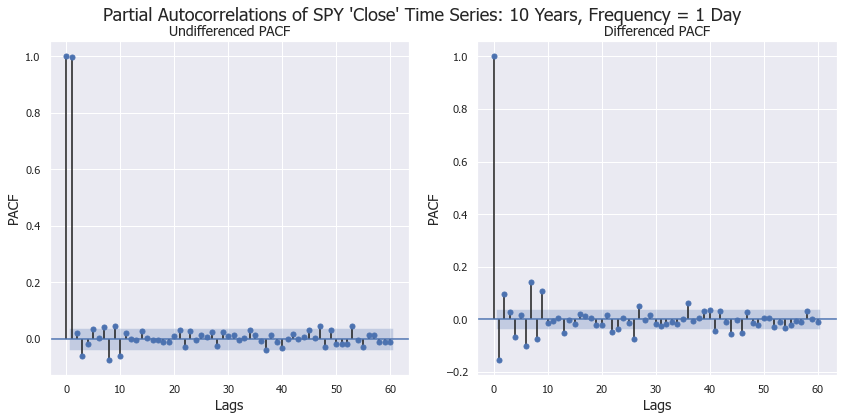

In [160]:
plot_pacf_with_diff(df_10Y_close, 'SPY \'Close\'', 10, 'years', '1 Day', lags=60, diffs=1)

Plot Autocorrelation with undifferenced and differenced data. This suggests MA terms of 1.

Functions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


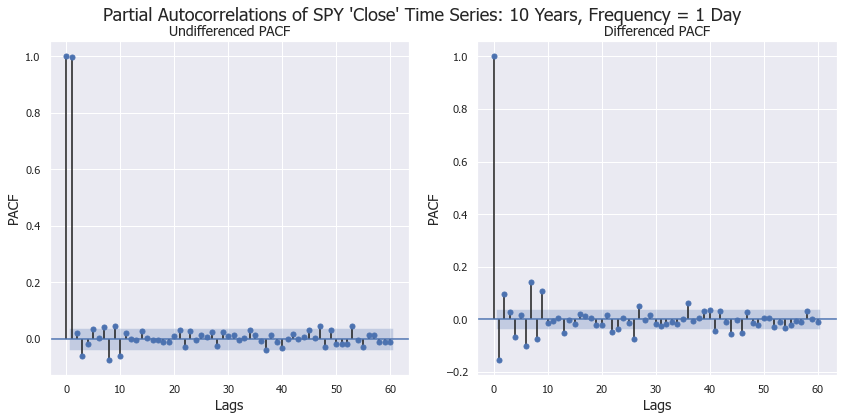

In [162]:
plot_pacf_with_diff(df_10Y_close, 'SPY \'Close\'', 10, 'years', '1 Day', lags=60, diffs=1)

## Plot Seasonal Decomposition

Plot seasonal decompositions of our endogenous variable. Testing with various seasonalities showed that the strongest is 4 years = 1008 trading days.

Functions.py loaded from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/data.


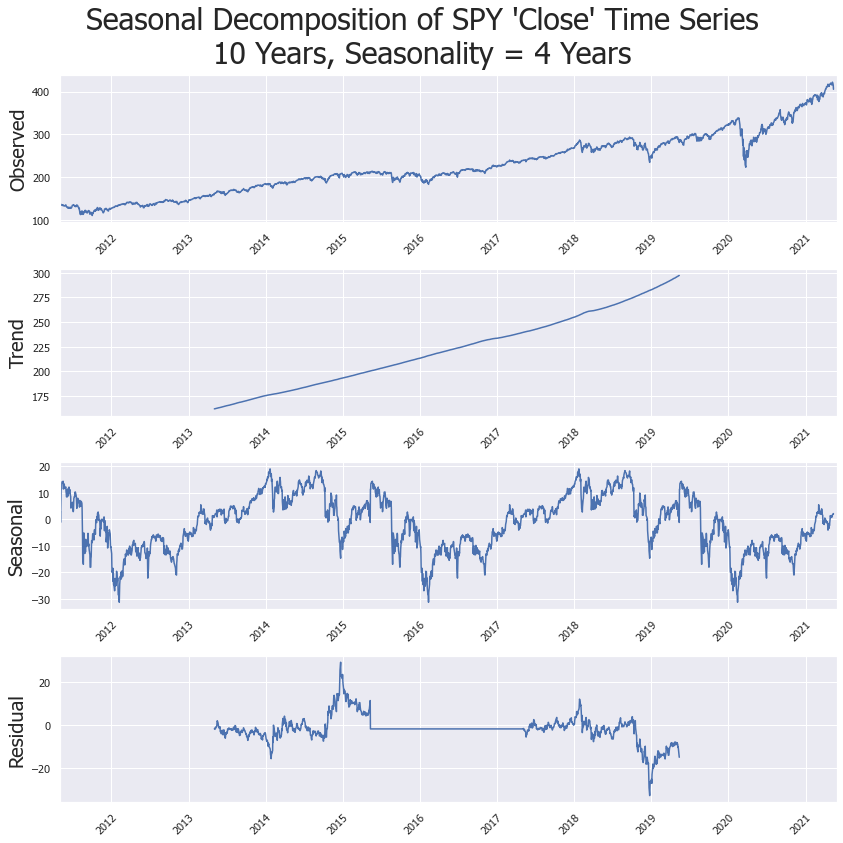

In [176]:
plot_seasonal_decomposition(df_10Y_close, 'SPY \'Close\'', 10, 'years', '1 Day', 1008, '4 Years')

Next best is 1 year = 252 trading days.

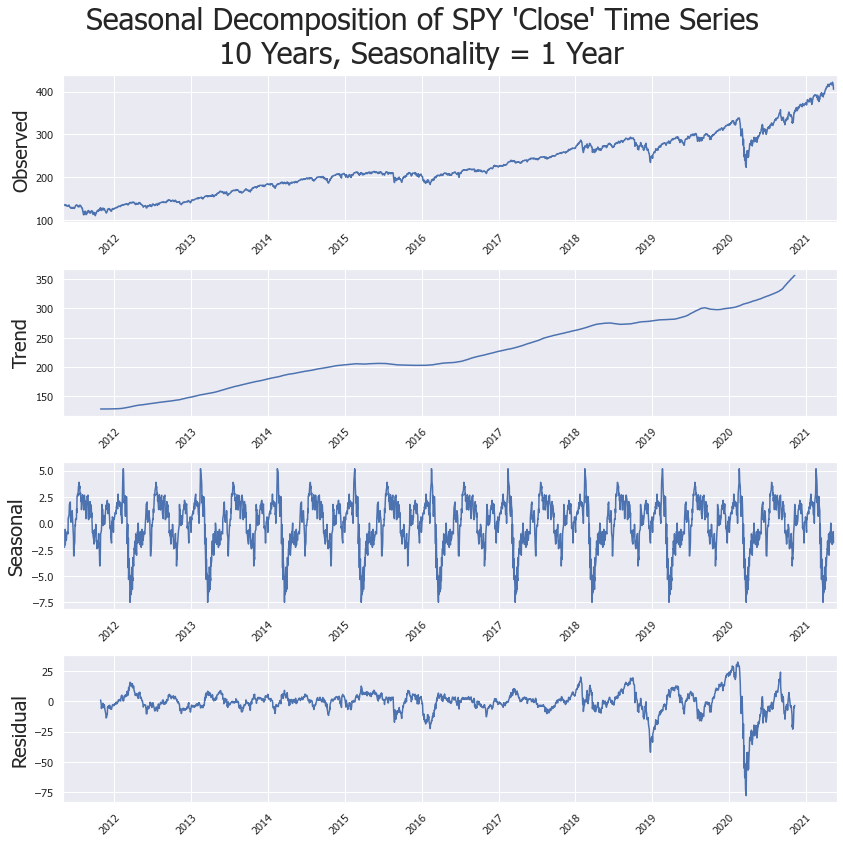

In [178]:
plot_seasonal_decomposition(df_10Y_close, 'SPY \'Close\'', 10, 'years', '1 Day', 252, '1 Year')

# Modeling

Time Series analysis and modeling is usually done via an implementation of [ARIMA](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average).
[SARIMAX](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html), the Python statsmodels implementation, leaves a bit to be desired; we tested with SARIMAX and achieved unsatisfactory results. We also looked into [Prophet](https://facebook.github.io/prophet/docs/quick_start.html), however the ability to tune parameters was limited.  

What we chose was to write a custom implementation of [pmdarima](http://alkaline-ml.com/pmdarima/); this is the `Pmdarima_Model` Class.
We also compared Linear Regression, Logistic Regression, and results were close to 50/50 predictions.

All our modeling validation is performed using a train-test split of `80/20` split, handled by our Class.

## Instatiate Class `Pmdarima_Model`

First we instantiate our Class, and give it some starting parameters. Of note are the four featurizers built-in to pmdarima:
DataFeaturizer - creates exogenous variables from the date index
FourierFeaturizer - uses Fourier transforms to model seasonality without using an explicit seasonal order (which can save massive computational time)
BoxCogEndogFeauturizer - help with data that is not normally distributed
LogEndogFeaturizer - uses logarithms to help with data with large magnitude, useful for our Volume time series

In [543]:
pam_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', f_seas=1008,
                            estimate_diffs=True, impute=False, verbose=0,
                            date=True, fourier=True, box=False, log=False)

## Run AutoARIMA

pmdarima has a built-in automatical parameter discovery function, which we test out as well. The output from this will not be the final model.

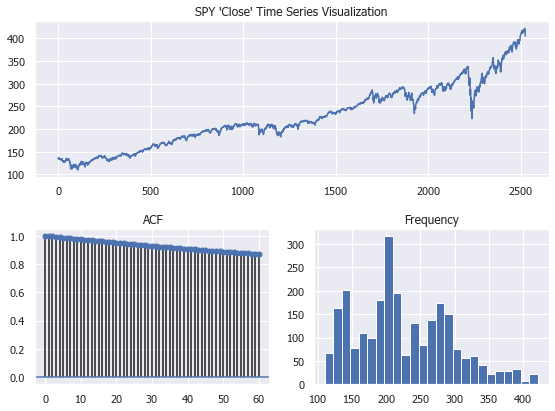

Best params:
  ARIMA(0, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer


In [180]:
pam_close_auto = pam_close.run_auto_pipeline(show_summary=True, verbose=0)

## Perform Step-Wise (aka Rolling) Cross-Validation

Next we will run a custom cross-validation sequence to run in-sample predictions one date at a time, starting from the beginning of our `test` set. Then we update our model with the next observed value, and repeat.

Done.
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_AA_best_model.pkl.



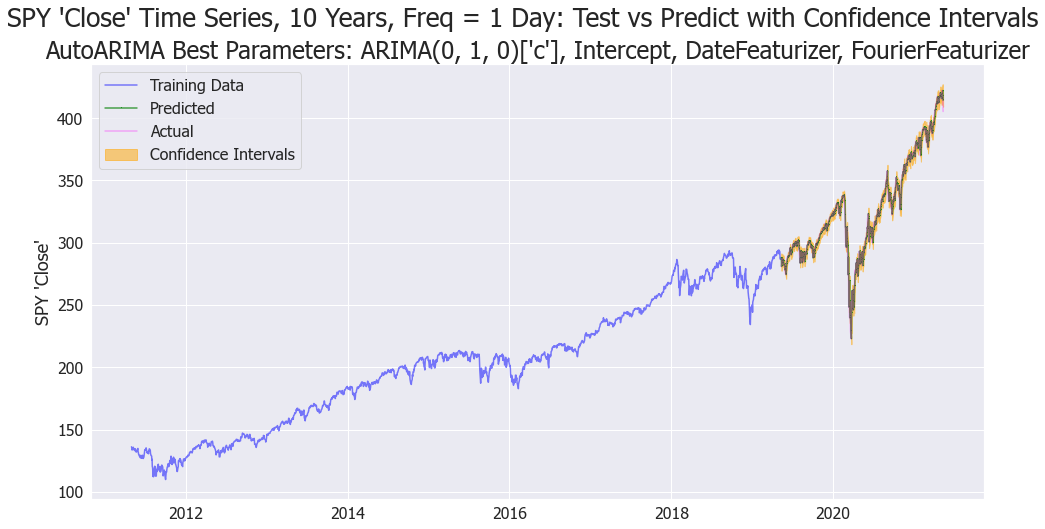

In [184]:
pam_close_AA_CV_scores = pam_close.run_stepwise_CV(dynamic=False, verbose=0, visualize=True)

## Manual GridSearch of Model Parameters

Not satisfied, we run a custom grid-search function to generate a list of potential models, and run the step-wise cross-validation sequence on each. All tests are recorded to file, and the best performing model is pickled.

A subset of the testing is shown here for brevity.

Setting up GridSearchCV...
Running normally.
Running step-wise cross-validation on model 1 of 1... Done.
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12701.524 | RMSE=4.656 | RMSE_pc=2.317% | SMAPE=0.976%
First viable model found, RMSE=4.656
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Close'_10Y_1D_GS_best_model.pkl.
GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(1, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=12701.524 | RMSE=4.656 | RMSE%=2.317% | SMAPE=0.976%


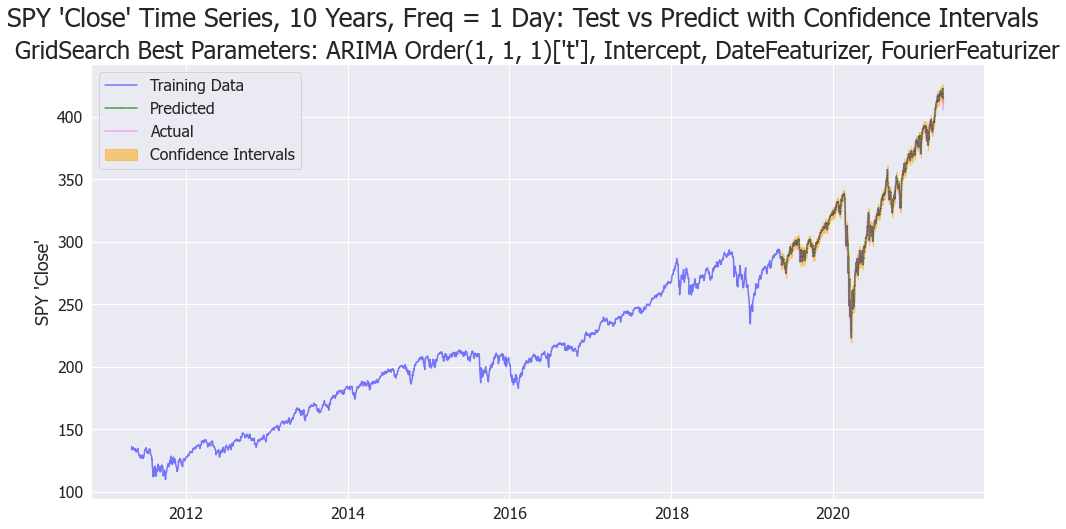

In [190]:
pam_close_best, scores = pam_close.run_gridsearch_CV(min_order=1, max_order=2, min_d=1, max_d=1, min_p=1, min_q=1,
                            with_intercept=True, f_m=1008, k=2, t_list='t',
                            date=True, fourier=True, box=False, log=False,
                            verbose=0, debug=0, parallel=False)

From running the GridSearch repeatedly, we found that ARIMA Order(4, 1, 6) worked well, with Fourier seasonality of 1008, order of 2. We can manually input it when running the prediction later.

## GridSearch on Exogenous Variables

We run similar processes for all our exogenous variables as well. We can skip the AutoARIMA step since we perform a grid-search anyway.

Setting up GridSearchCV...
Running normally.
Running step-wise cross-validation on model 1 of 1... 
Done.
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11728.143 | RMSE=4.252 | RMSE_pc=2.116% | SMAPE=0.921%
First viable model found, RMSE=4.252
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Open'_10Y_1D_GS_best_model.pkl.
GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11728.143 | RMSE=4.252 | RMSE%=2.116% | SMAPE=0.921%


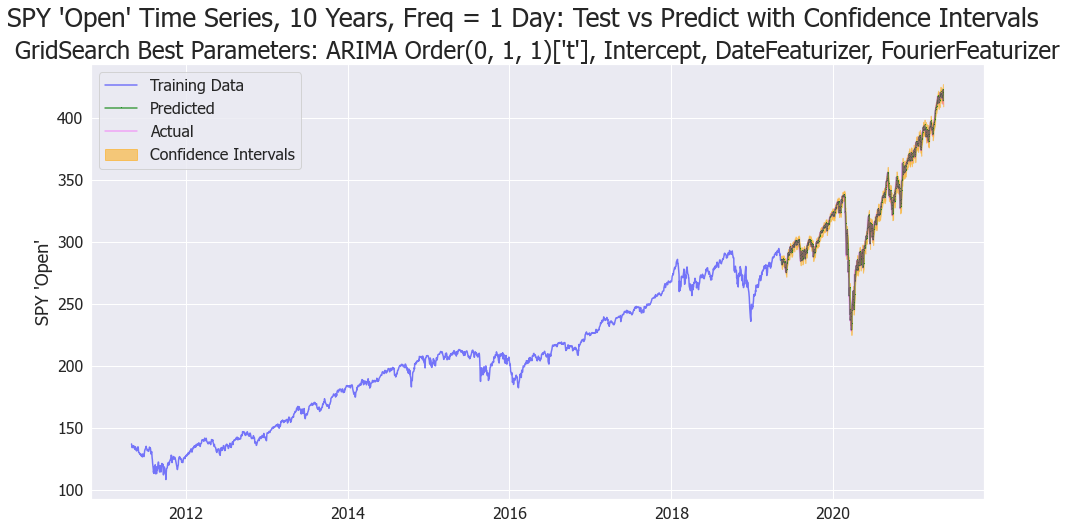

In [208]:
# Open
pam_open = Pmdarima_Model(df_10Y_open, 'SPY \'Open\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0,
                            date=True, fourier=True, box=False, log=False)
pam_open_best, scores = pam_open.run_gridsearch_CV(max_order=1, max_d=1, min_d=1, min_p=0, min_q=1,
                            t_list=['t'], with_intercept=True, f_m=1008, k=2,
                            date=True, fourier=True, box=False, log=False,
                            verbose=0, debug=False, parallel=False)

Setting up GridSearchCV...
Running normally.
Running step-wise cross-validation on model 1 of 1... Done.
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=10818.914 | RMSE=3.515 | RMSE_pc=1.742% | SMAPE=0.748%
First viable model found, RMSE=3.515
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'High'_10Y_1D_GS_best_model.pkl.
GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(1, 1, 0)['ct'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=10818.914 | RMSE=3.515 | RMSE%=1.742% | SMAPE=0.748%


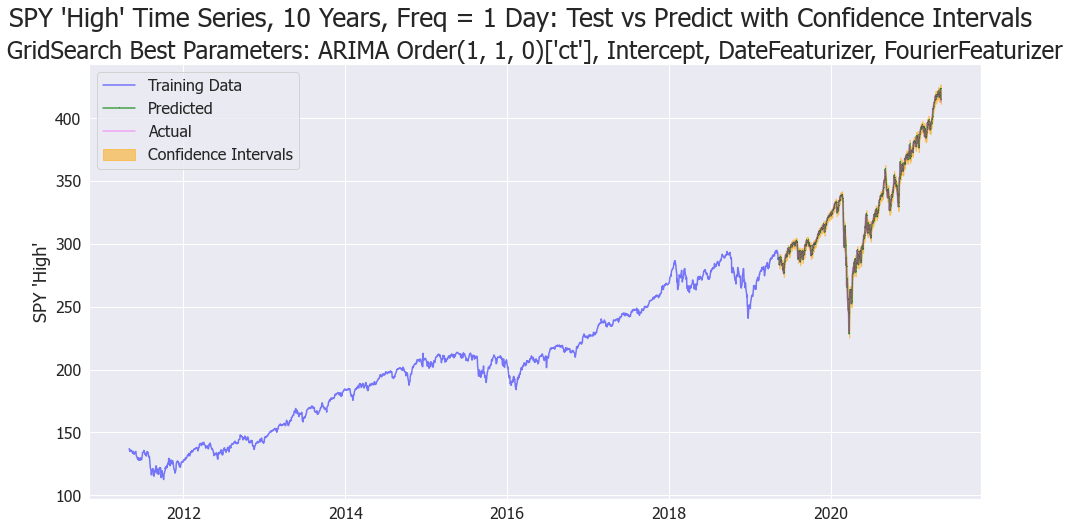

In [210]:
# High
pam_high = Pmdarima_Model(df_10Y_high, 'SPY \'High\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0,
                            date=True, fourier=False, box=False, log=False)
pam_high_best, scores = pam_high.run_gridsearch_CV(max_order=1, max_d=1, min_d=1, min_p=1, min_q=0,
                            t_list=['ct'], with_intercept=True, f_m=1008, k=2,
                            date=True, fourier=True, box=False, log=False,
                            verbose=0, debug=False, parallel=False)

Setting up GridSearchCV...
Based on parameters given, 0 models built out of 1 in grid.
Running normally.
Running step-wise cross-validation on model 1 of 1... Done.
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11527.878 | RMSE=4.040 | RMSE_pc=2.021% | SMAPE=0.890%
First viable model found, RMSE=4.040
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Low'_10Y_1D_GS_best_model.pkl.
GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(0, 1, 1)['t'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11527.878 | RMSE=4.040 | RMSE%=2.021% | SMAPE=0.890%


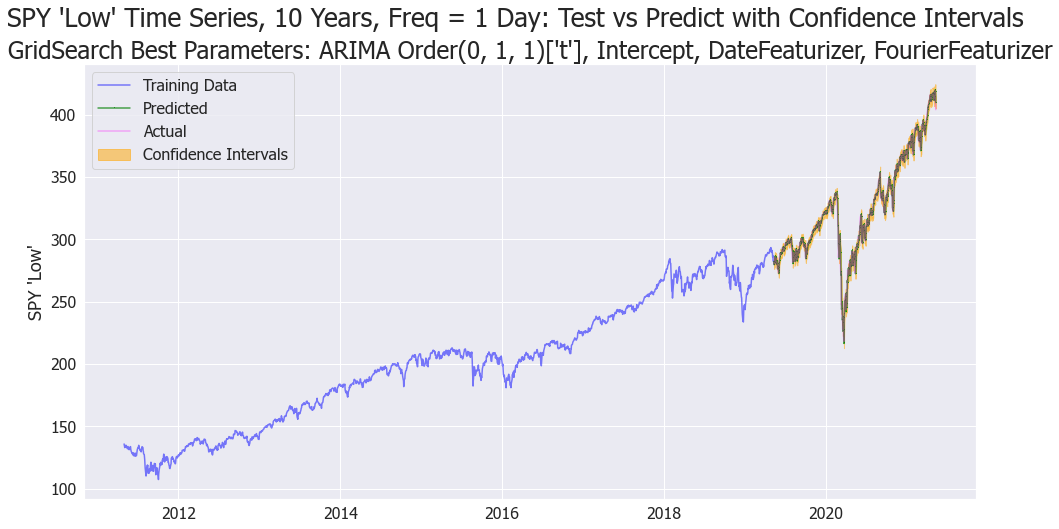

In [238]:
# Low
pam_low = Pmdarima_Model(df_10Y_low, 'SPY \'Low\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0,
                            date=True, fourier=False, box=False, log=False)
pam_low_best, scores = pam_low.run_gridsearch_CV(max_order=1, max_d=1, min_d=1, min_p=0, min_q=1,
                            t_list=['t'], with_intercept=True, f_m=1008, k=2,
                            date=True, fourier=True, box=False, log=False,
                            verbose=0, debug=False, parallel=False)

Setting up GridSearchCV...
Running normally.
Running step-wise cross-validation on model 1 of 1... Done.
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11726.953 | RMSE=4.517 | RMSE_pc=2.492% | SMAPE=0.962%
First viable model found, RMSE=4.517
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Adjusted_Close'_10Y_1D_GS_best_model.pkl.
GridsearchCV Completed.

Top 10 models from this run:
Model[ARIMA Order(1, 1, 0)['c'], Intercept, DateFeaturizer, FourierFeaturizer]: AIC=11726.953 | RMSE=4.517 | RMSE%=2.492% | SMAPE=0.962%


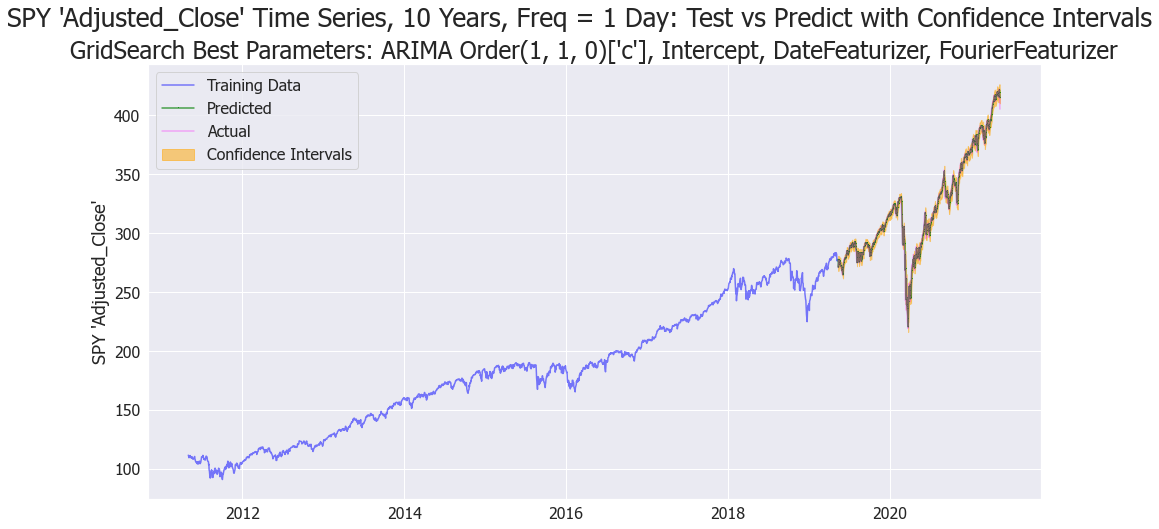

In [212]:
# Adjusted Close
pam_a_close = Pmdarima_Model(df_10Y_a_close, 'SPY \'Adjusted_Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0,
                            date=True, fourier=False, box=False, log=False)
pam_a_close_best, scores = pam_a_close.run_gridsearch_CV(max_order=1, max_d=1, min_d=1, min_p=1, min_q=0,
                            t_list=['c'], with_intercept=True, f_m=1008, k=2,
                            date=True, fourier=True, box=False, log=False,
                            verbose=0, debug=False, parallel=False)

Setting up GridSearchCV...
No models were scored this run.
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/SPY_'Volume'_10Y_1D_GS_best_model.pkl.


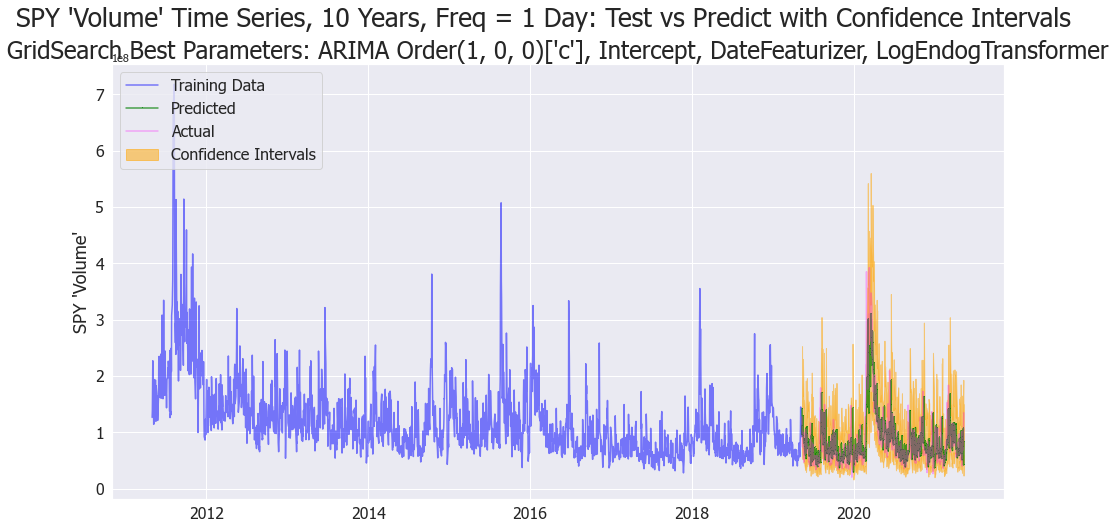

In [217]:
# Volume
pam_vol = Pmdarima_Model(df_10Y_vol, 'SPY \'Volume\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0,
                            date=True, fourier=False, box=False, log=False)
pam_vol_best, scores = pam_vol.run_gridsearch_CV(max_order=1, max_d=1, min_d=1, min_p=0, min_q=1,
                            t_list=None, with_intercept=False, f_m=252, k=2,
                            date=True, fourier=True, box=False, log=True,
                            verbose=0, debug=False, parallel=False)

Setting up GridSearchCV...
No models were scored this run.
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/Future_'Close'_10Y_1D_GS_best_model.pkl.


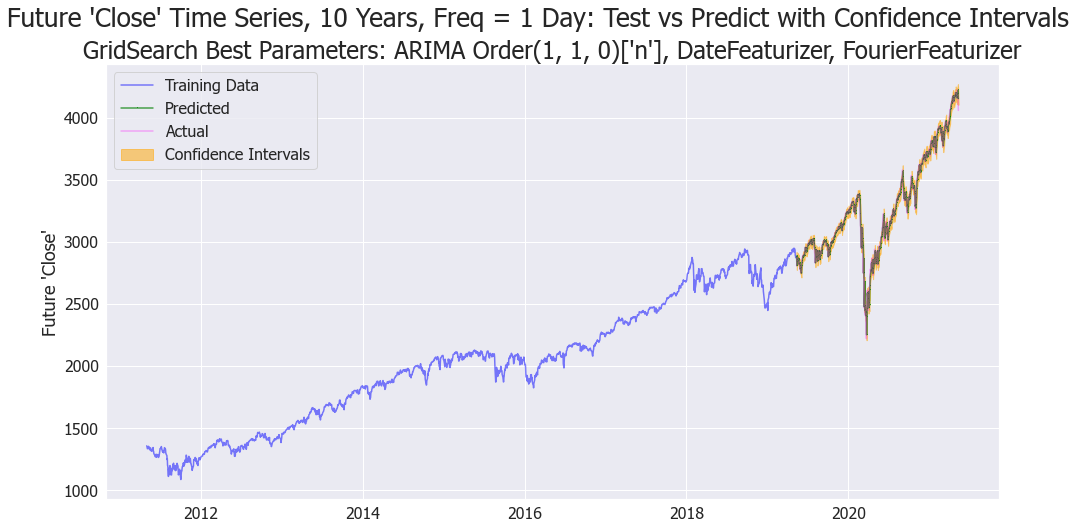

In [591]:
# Spy Futures Close
pam_f_close = Pmdarima_Model(df_f_10Y_close, 'Future \'Close\'', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0,
                            date=True, fourier=False, box=False, log=False)
pam_f_close_best, scores = pam_f_close.run_gridsearch_CV(max_order=1, max_d=1, min_d=1, min_p=1, min_q=0,
                            t_list=['n'], with_intercept=False, f_m=1008, k=2,
                            date=True, fourier=True, box=False, log=False,
                            verbose=0, debug=True, parallel=False)

Setting up GridSearchCV...
No models were scored this run.
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/TSY_10Y_Note_10Y_1D_GS_best_model.pkl.


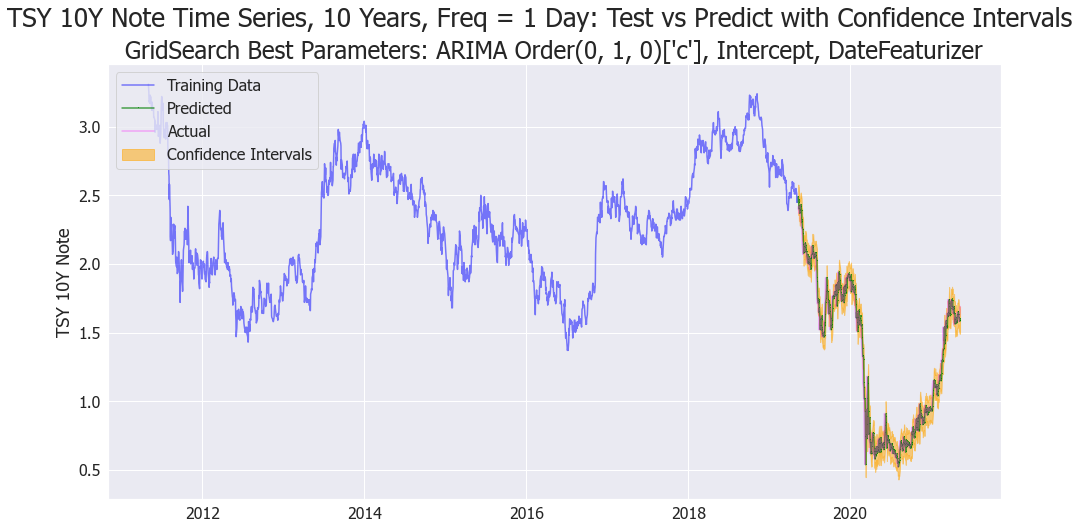

In [220]:
# Treasury 10 Year Note Yield
pam_tsy = Pmdarima_Model(tsy_10Y_df, 'TSY 10Y Note', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0,
                            date=True, fourier=False, box=False, log=False)
pam_tsy_best, scores = pam_tsy.run_gridsearch_CV(max_order=1, max_d=1, min_d=1, min_p=1, min_q=0,
                            t_list=['n'], with_intercept=False,
                            date=True, fourier=False, box=False, log=False,
                            verbose=0, debug=True, parallel=False)

Setting up GridSearchCV...
No models were scored this run.
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/Fed_Funds_Target_Rate_10Y_1D_GS_best_model.pkl.


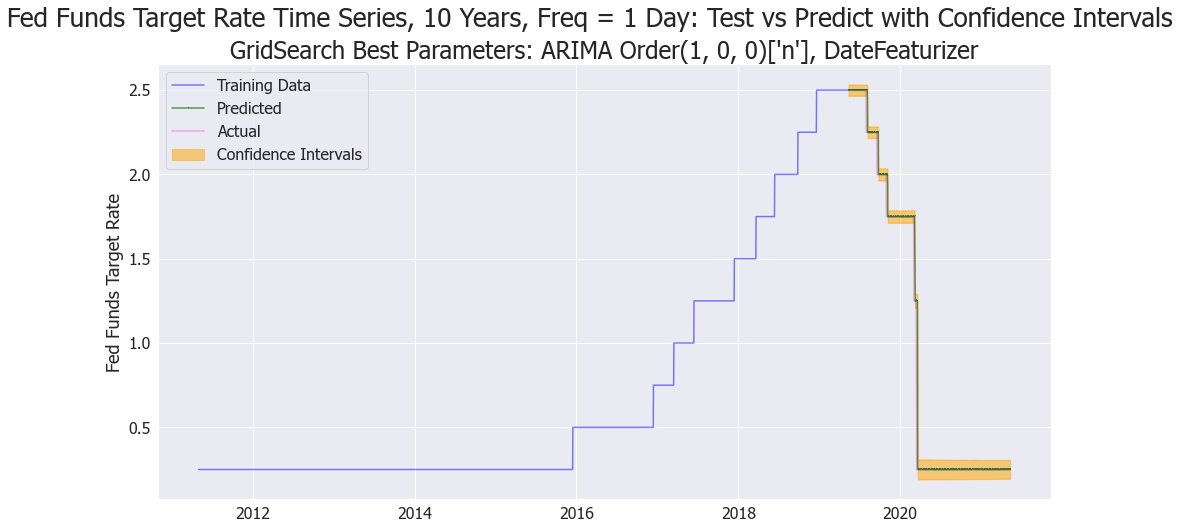

In [506]:
# Fed Funds Target Rate
pam_fed_funds_t = Pmdarima_Model(fed_t_10Y_df, 'Fed Funds Target Rate', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0,
                            date=True, fourier=False, box=False, log=False)
pam_fed_funds_t_best, scores = pam_fed_funds_t.run_gridsearch_CV(max_order=1, max_d=1, min_d=1, min_p=1, min_q=0,
                            t_list=['n'], with_intercept=False,
                            date=True, fourier=False, box=False, log=False,
                            verbose=0, debug=True, parallel=False)

Setting up GridSearchCV...
No models were scored this run.
Loading best model from /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/models/Fed_Funds_Effective_Rate_10Y_1D_GS_best_model.pkl.


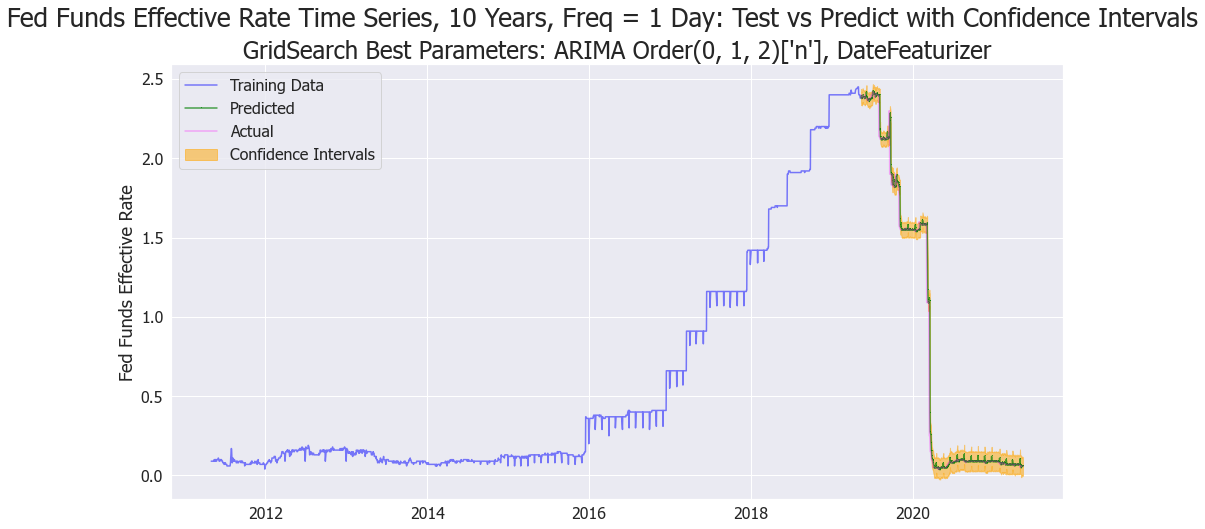

In [507]:
# Fed Funds Effective Rate
pam_fed_funds = Pmdarima_Model(fed_10Y_df, 'Fed Funds Effective Rate', train_size=80,
                            n=10, periods='years', freq='1 Day', seas=252,
                            estimate_diffs=True, impute=False, verbose=0,
                            date=True, fourier=False, box=False, log=False)
pam_fed_funds_best, scores = pam_fed_funds.run_gridsearch_CV(max_order=0, max_d=1, min_d=1, min_p=0, min_q=0,
                            t_list=['n'], with_intercept=False, f_m=252, k=2,
                            date=True, fourier=False, box=False, log=False,
                            verbose=0, debug=True, parallel=False)

# Historical Simulation

So our model is looking decent, but how does it do in the real world? Luckily we have historical data with which to compare against.  
We can run our model against historical prices and determine if what the model tells us to do will have turned a profit.

First we create a concatenated DataFrame of all exogenous variables on which our model will be fit.

In [617]:
exog_hist_df = Pmdarima_Model.join_exog_data(opt_exp_10Y_df,
#                                                  df_10Y_open,
#                                                  df_10Y_high,
#                                                  df_10Y_low,
#                                                  df_10Y_a_close,
                                                 df_10Y_vol,
#                                                  df_f_10Y_close,
                                                 tsy_10Y_df,
                                                 fed_t_10Y_df,
                                                 fed_10Y_df)
exog_hist_df.reset_index(inplace=True)

## `I SPY` Model Buy/Sell Strategy

Using a new Class `Model_Historical_Simuluation`, we run the simulation using default parameters and see where we land.  
The default parameters use the following simplified strategy:
1. For each day of the time series, compute the `predicted price` for the next day and the 68% `confidence intervals` (equivalent to 1 <i>standard deviation `z`</i> above and below) for the predictions.  
The upper and lower range of the confidence intervals are now the <b>quote trigger</b> prices.
2. If you own shares, and the observed price for the next day exceeds the upper <b>quote trigger price</b>, place a Limit SELL order with a limit offset `lim` of <i>1% greater</i> than the upper <b>quote trigger price</b>. If SPY reaches that limit price that day, the trade is executed and you sell your shares.
3. If you have cash, and the observed price for the day exceeds the lower <b>quote trigger price</b>, place a Limit BUY order with a limit offset `lim` of <i>1% less</i> than the lower <b>quote trigger price</b>. If SPY reaches that limit price that day, the trade is executed and you buy shares.

Starting conditions: Buy 100 shares @ the closing price for first day.

In [254]:
1 - (2-stats.norm.cdf(1)*2)

0.6826894921370859

In [241]:
mod_sim = Model_Historical_Simuluation(pam_close_best, spy_df_10Y, exog_hist_df, shares=100,
                                       z=1, limit_offset_pc=1, verbose=1)
y_hat, conf_ints, mod_profit, mod_profit_pc, mod_profit_df = mod_sim.main()

Running `I SPY` model historical simulation...



> 
Total profit is $16,996.31, which is a 124.77% profit.


124.77%, seems like a lot? How well would we have done if we just bought shares at the beginning of the time series and held for 10 years?

## `Buy and Hold` Strategy

Compute simple `Buy and Hold` strategy performance...

In [242]:
bh_profit, bh_profit_pc, bh_profit_df = calc_buy_hold_profit(spy_df_10Y, shares=100)

Starting portfolio value was $13,622.00.
Final portfolio value is $40,541.00.
Total profit is $26,919.00, which is a 197.61% profit.


Ah, so we did not beat the market itself.

## Comparison

Let's visualize and compare:

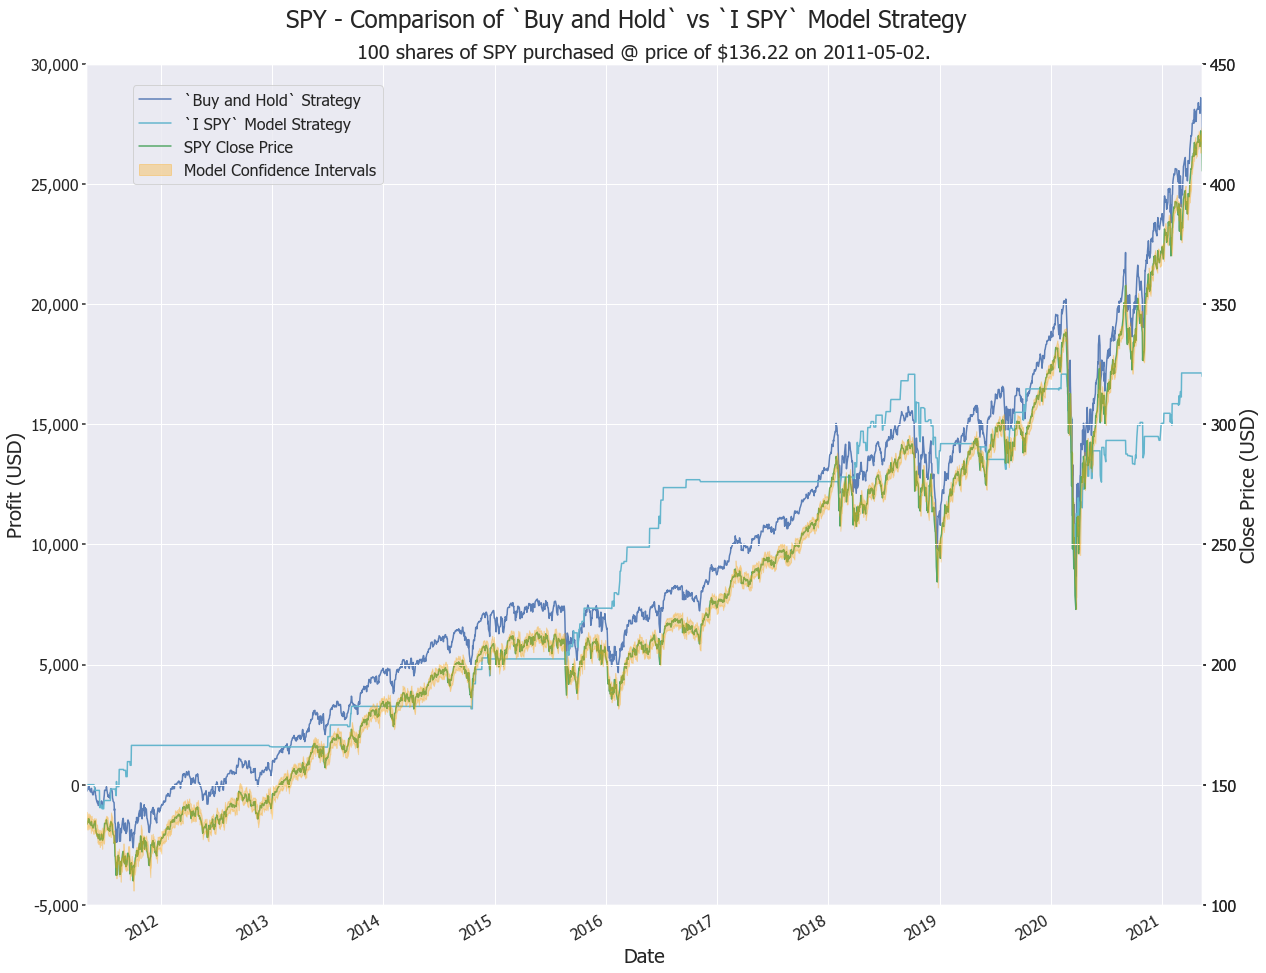

In [243]:
plot_profits(100, bh_profit_df, mod_profit_df, df_10Y_close, conf_ints)

Semes like there's room for improvement.  
Can we adjust the confidence interval quote triggers and the limit prices by tuning the `z` and the `lim` parameters using a grid-search?

## GridSearch on Strategy Parameters

In [246]:
mod_profit_GS = Gridsearch_Calc_Profit('SPY 10Y', pam_close_best, spy_df_10Y, exog_hist_df, steps=40, z_min=0, z_max=2,
                                             lim_min=-0.5, lim_max=3.5, shares=100, visualize=False, verbose=0)
mod_profit_GS_df = mod_profit_GS.main()

Running GridSearchCV on SPY 10Y model trading strategy...
Running 1600 simulations using `z` in (0, 2) and `lim` in (-0.5, 3.5).
File exists, overwriting.
Saved to /Users/wax/Documents/Classes/FS Data Science Immersive/Flatiron_Materials/Feb 1/wax_capstone_project/model_profit_GS/SPY_10Y_Profit_CV.pkl.


Let's take a look at our findings:

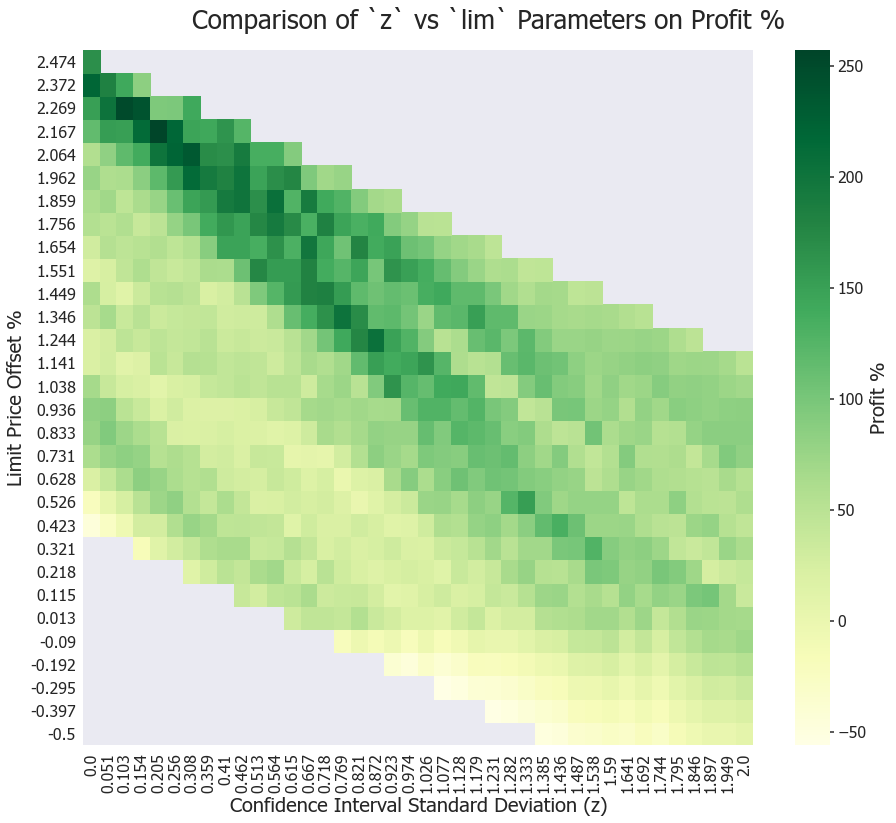

In [247]:
mod_profit_GS.plot_profit_heatmap()

In [287]:
GS_max_profit, GS_best_lim = mod_profit_GS.get_max_profit()

Best profit achieved with `z` = 0.205 and `lim` = 2.167:
$35,020.60 | 257.09%


How did our best model do?

In [288]:
GS_mod_sim = Model_Historical_Simuluation(pam_close_best, spy_df_10Y, exog_hist_df, shares=100,
                                       z=GS_best_lim[0], limit_offset_pc=GS_best_lim[1], verbose=1)
GS_y_hat, GS_conf_ints, GS_mod_profit, GS_mod_profit_pc, GS_mod_profit_df = GS_mod_sim.main()

Running `I SPY` model historical simulation...



> 
Total profit is $35,020.60, which is a 257.09% profit.


Much better! And graphing it:

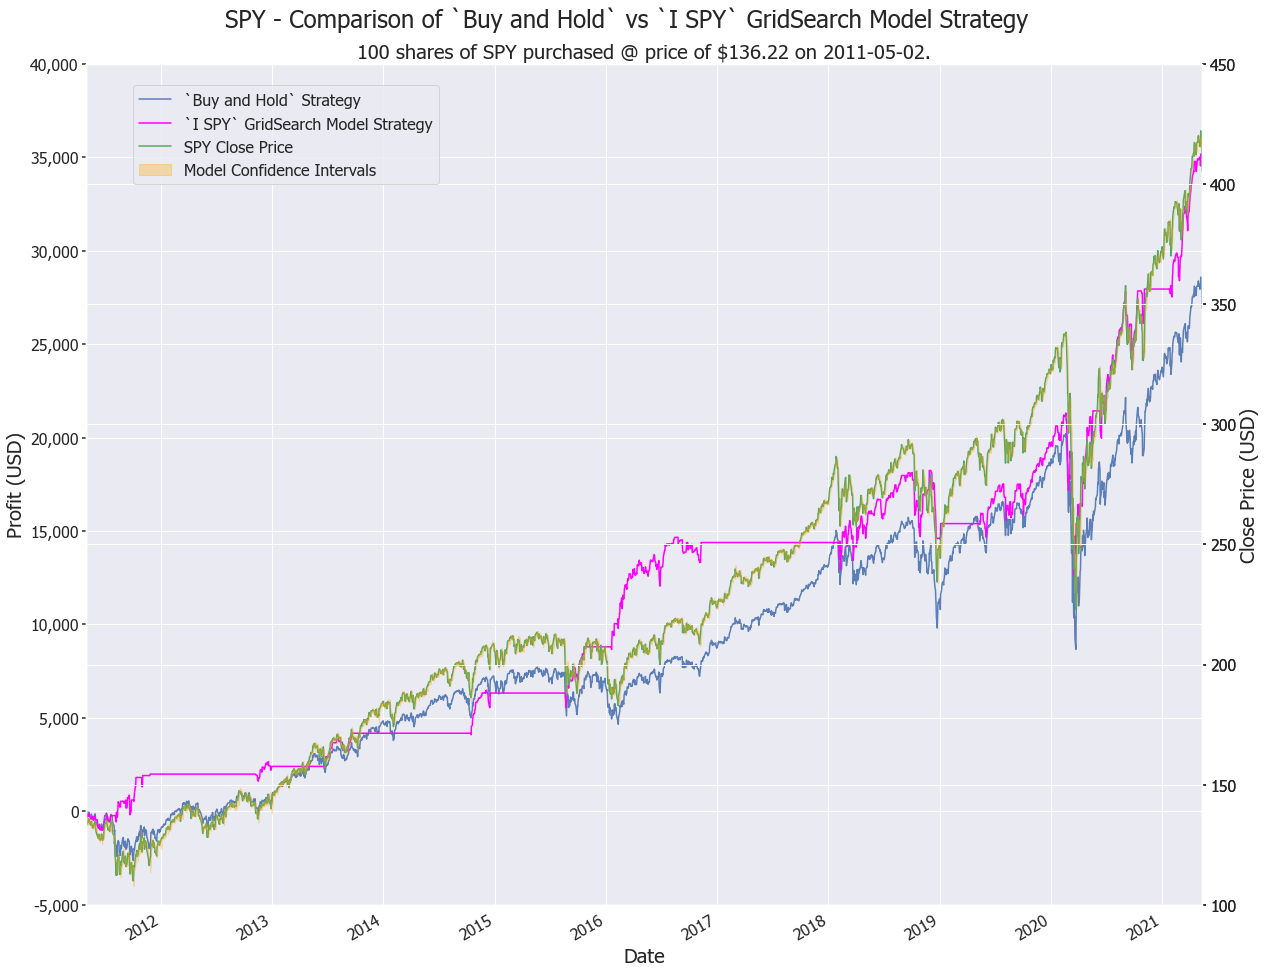

In [291]:
plot_profits(100, bh_profit_df, GS_mod_profit_df, df_10Y_close, GS_conf_ints, GS=True)

# Forecasting

Now that we've determined that our model holds some water, we forecast future prices for SPY and see what may happen in the coming weeks, let's say 52 trading days because that's a number often used in the trading world.

First we need to gather all our exogenous variables. This means running models on each variable and predicting 52 days out on each. 

## Predicting on Exogenous Variables

In [ ]:
open_hat_df, open_hat, new_dates_df, open_conf_ints = pam_open.run_prediction(pam_open_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=0, lookback=252, visualize=False)

high_hat_df, high_hat, new_dates_df, high_conf_ints = pam_high.run_prediction(pam_high_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=0, lookback=252, visualize=False)

low_hat_df, low_hat, new_dates_df, low_conf_ints = pam_low.run_prediction(pam_low_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=0, lookback=252, visualize=False)

a_close_hat_df, a_close_hat, new_dates_df, a_close_conf_ints = pam_a_close.run_prediction(pam_a_close_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=0, lookback=252, visualize=False)

vol_hat_df, vol_hat, new_dates_df, vol_conf_ints = pam_vol.run_prediction(pam_vol_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=0, lookback=252, visualize=False)

f_close_hat_df, f_close_hat, new_dates_df, f_close_conf_ints = pam_f_close.run_prediction(pam_f_close_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=0, lookback=252, visualize=False)

tsy_hat_df, tsy_hat, new_dates_df, tsy_conf_ints = pam_tsy.run_prediction(pam_tsy_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=0, lookback=252, visualize=False)

fed_funds_t_hat_df, fed_funds_t_hat, new_dates_df, fed_funds_t_conf_ints = pam_fed_funds_t.run_prediction(pam_fed_funds_t_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=0, lookback=252, visualize=False)

fed_funds_hat_df, fed_funds_hat, new_dates_df, fed_funds_conf_ints = pam_fed_funds.run_prediction(pam_fed_funds_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=0, lookback=252, visualize=False)

Unfortunately, without pulling in "meta"-exogenous variables for the Open, High, Low, Adjusted Close, and SPY Futures Close, we aren't getting very meaningful results. From testing, if we take these results and fit our SPY Close model on it, we will over-fit and produce essentially a straight result. So we will exclude these from our final model.

First we reset our historical dataset.

In [ ]:
exog_hist_df = Pmdarima_Model.join_exog_data(opt_exp_10Y_df,
                                                 df_10Y_vol,
                                                 tsy_10Y_df,
                                                 fed_t_10Y_df,
                                                 fed_10Y_df)
exog_hist_df.reset_index(inplace=True)

As aforementioned, we don't need to predict future values for our `is_option_expiry` variable, we can generate them. But we do need to reset the index on it to match the new indices:

In [ ]:
tsy_hat_df, tsy_hat, new_dates_df, tsy_conf_ints = pam_tsy.run_prediction(pam_tsy_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=0, lookback=252, visualize=False)

fed_funds_t_hat_df, fed_funds_t_hat, new_dates_df, fed_funds_t_conf_ints = pam_fed_funds_t.run_prediction(pam_fed_funds_t_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=0, lookback=252, visualize=False)

fed_funds_hat_df, fed_funds_hat, new_dates_df, fed_funds_conf_ints = pam_fed_funds.run_prediction(pam_fed_funds_best, 52, fin=False,
                            en_ex='exog', func='GS', verbose=0, lookback=252, visualize=False)

In [594]:
opt_exp_fc_df = create_option_expiry_df(N=52, func='forecast', freq=CBD)
opt_exp_fc_df.index = new_dates_df.index

Concatenate all our exogenous variable forecasts together.

In [618]:
exog_fc_df = Pmdarima_Model.join_exog_data(new_dates_df,
                                           opt_exp_fc_df,
                                           vol_hat_df,
                                           tsy_hat_df,
                                           fed_funds_t_hat_df,
                                           fed_funds_hat_df
                                          )

## Predicting on SPY Close

As aforementioned, we can manually input a model. Let's use our best performing GridSearch model.

In [643]:
date_feat = pm.preprocessing.DateFeaturizer(
    column_name="date",
    with_day_of_week=True,
    with_day_of_month=True)
_, X_train_feats = date_feat.fit_transform(df_10Y_close.values, pd.DataFrame(df_10Y_close.index))
pam_close_best = pm.pipeline.Pipeline(steps=[('date', pm.preprocessing.DateFeaturizer(column_name='date')),
                ('fourier', pm.preprocessing.FourierFeaturizer(k=4, m=1008)),
                ('fourier2', pm.preprocessing.FourierFeaturizer(k=4, m=252)),
                ('fourier3', pm.preprocessing.FourierFeaturizer(k=4, m=252/4)),
                ('arima',
                 pm.ARIMA(maxiter=200, order=(4, 1, 6), suppress_warnings=True,
                       trend='t'))])
# pam_close.mod_pipe = pam_close_best

In [633]:
pam_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80, order=(4, 1, 6),
                            n=10, periods='years', freq='1 Day', trend='t', with_intercept=True,
                            estimate_diffs=True, impute=False, verbose=0, f_seas=1008, k=4,
                            date=True, fourier=True, box=False, log=False)

Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


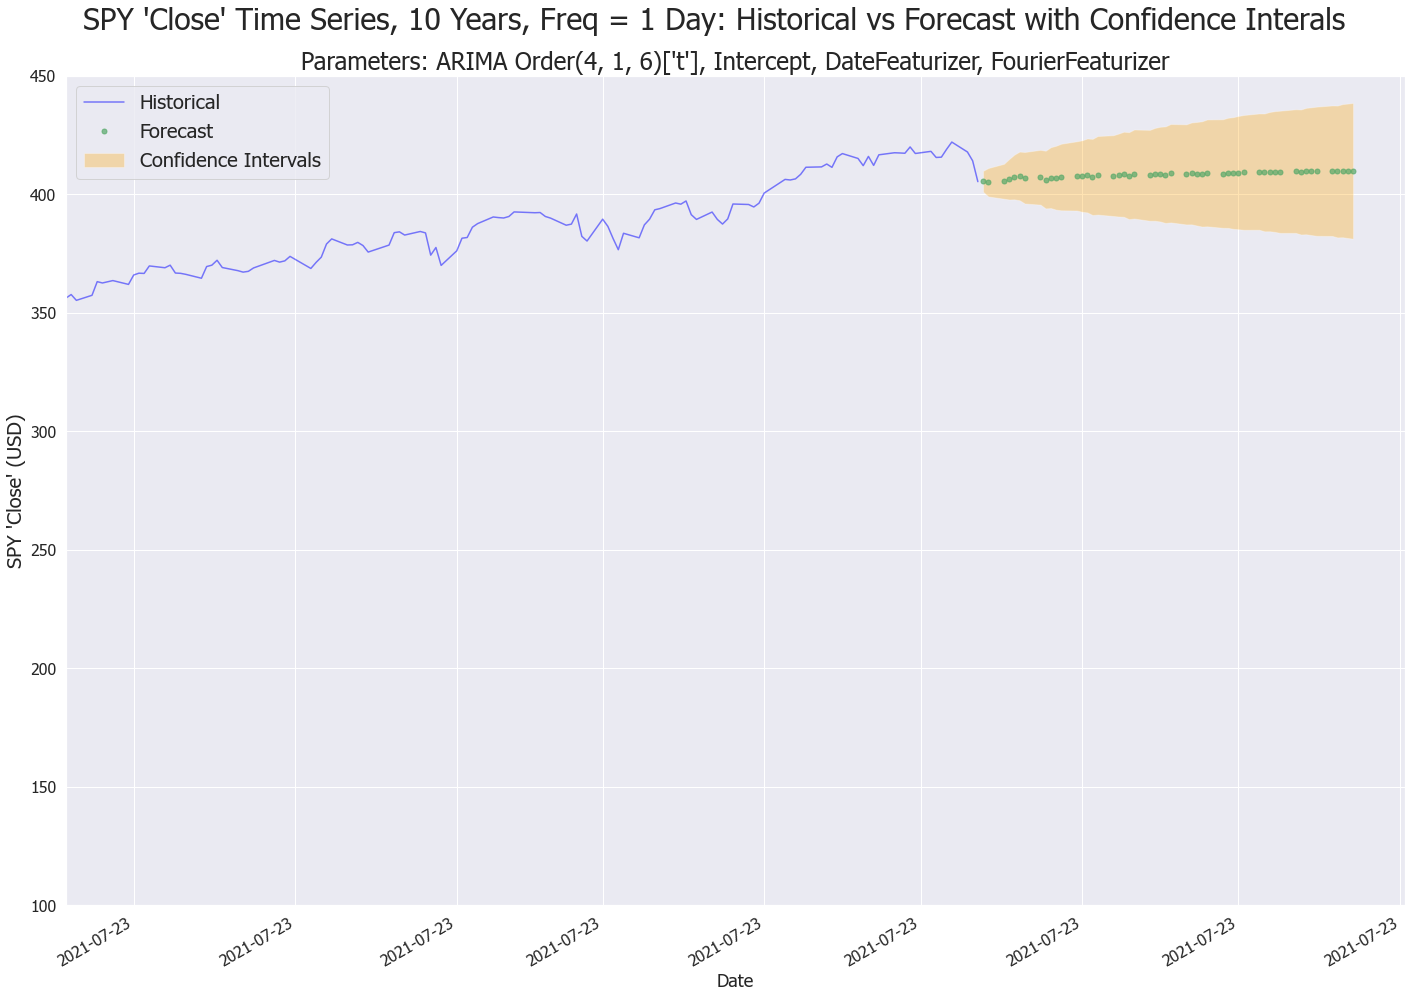

In [672]:
close_hat_df, close_hat, new_dates_df, close_conf_ints = pam_close.run_prediction(model=None, days_fc=52, fin=False,
                            exog_fc_df=exog_fc_df, exog_hist_df=exog_hist_df, en_ex='endo', ohlc_df=spy_df_10Y,
                            func='adhoc', lookback=252, verbose=1, visualize=True)

And now, we are ready to run the forecast on our Spy closing price...

In [635]:
pam_close = Pmdarima_Model(df_10Y_close, 'SPY \'Close\'', train_size=80, order=(4, 1, 6),
                            n=10, periods='years', freq='1 Day', f_seas=1008, trend='t', with_intercept=True,
                            estimate_diffs=True, impute=False, verbose=0,
                            date=True, fourier=True, box=False, log=False)

Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


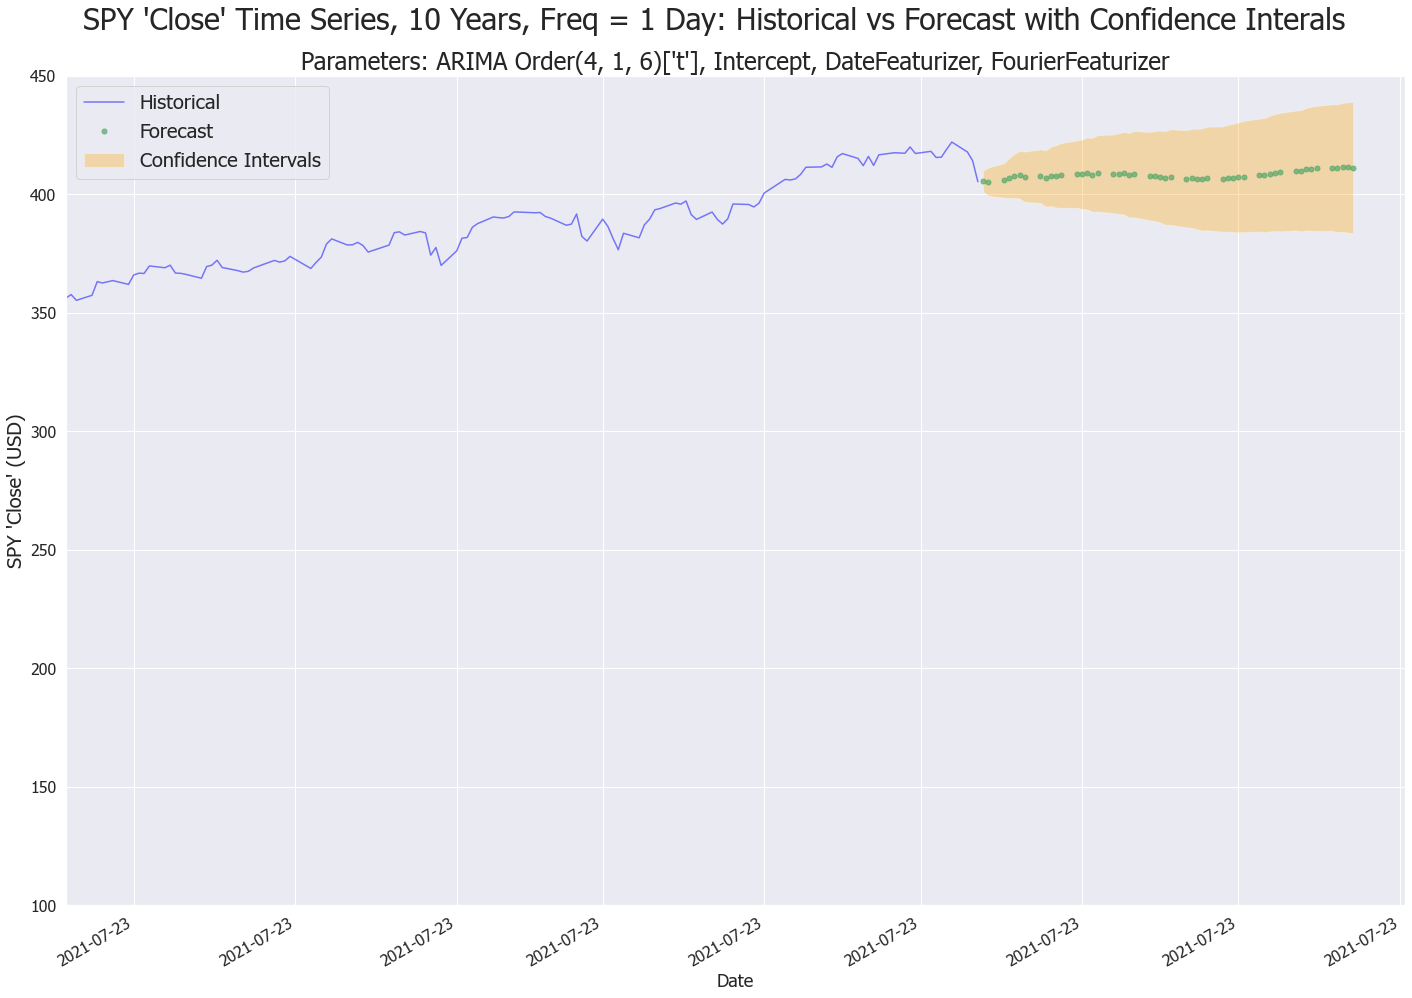

In [674]:
close_hat_df, close_hat, new_dates_df, close_conf_ints = pam_close.run_prediction(model=pam_close_best, days_fc=52, fin=False,
                            exog_fc_df=exog_fc_df, exog_hist_df=exog_hist_df, en_ex='endo', ohlc_df=spy_df_10Y,
                            func='adhoc', lookback=252, verbose=1, visualize=True)

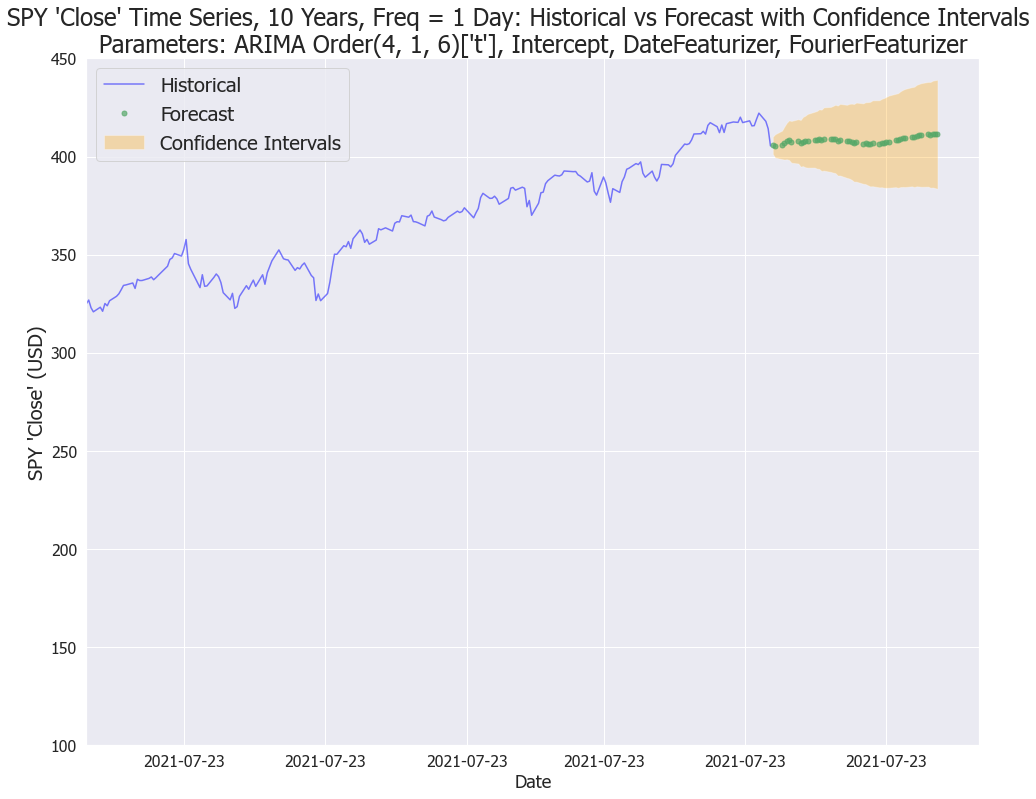

In [692]:
pam_close.plot_forecast_conf(hist_df=df_10Y_close, y_hat=close_hat_df, lookback=252, func='adhoc', days_fc=5)

In [693]:
for index in range(10):
    x = np.clip(int(index + 0.5), 0, 4 - 1)
    print(x)

0
1
2
3
3
3
3
3
3
3


In [683]:
len(pam_close.df_with_fc[-252-52:].index.date)

304

For a fun graph, let's gather only the OHLC info and display the candlestick graph of it.

In [ ]:
open_hat_df, open_hat, new_dates_df, open_conf_ints = pam_open.run_prediction(pam_close_best, 52,
                            exog_fc_df=exog_fc_df, exog_hist_df=exog_hist_df, en_ex='endo', ohlc_df=spy_df_10Y,
                            verbose=0, visualize=False)

high_hat_df, high_hat, new_dates_df, high_conf_ints = pam_high.run_prediction(pam_close_best, 52,
                            exog_fc_df=exog_fc_df, exog_hist_df=exog_hist_df, en_ex='endo', ohlc_df=spy_df_10Y,
                            verbose=0, visualize=False)

low_hat_df, low_hat, new_dates_df, low_conf_ints = pam_low.run_prediction(pam_close_best, 52,
                            exog_fc_df=exog_fc_df, exog_hist_df=exog_hist_df, en_ex='endo', ohlc_df=spy_df_10Y,
                            verbose=0, visualize=False)

ohlc_fc_df = open_hat_df.join(high_hat_df).join(low_hat_df).join(close_hat_df)

Running Fit and Predict on Endogenous variable SPY 'Close'...
Successfully fit model on historical observations.
Successfully forecasted 52 days forward.


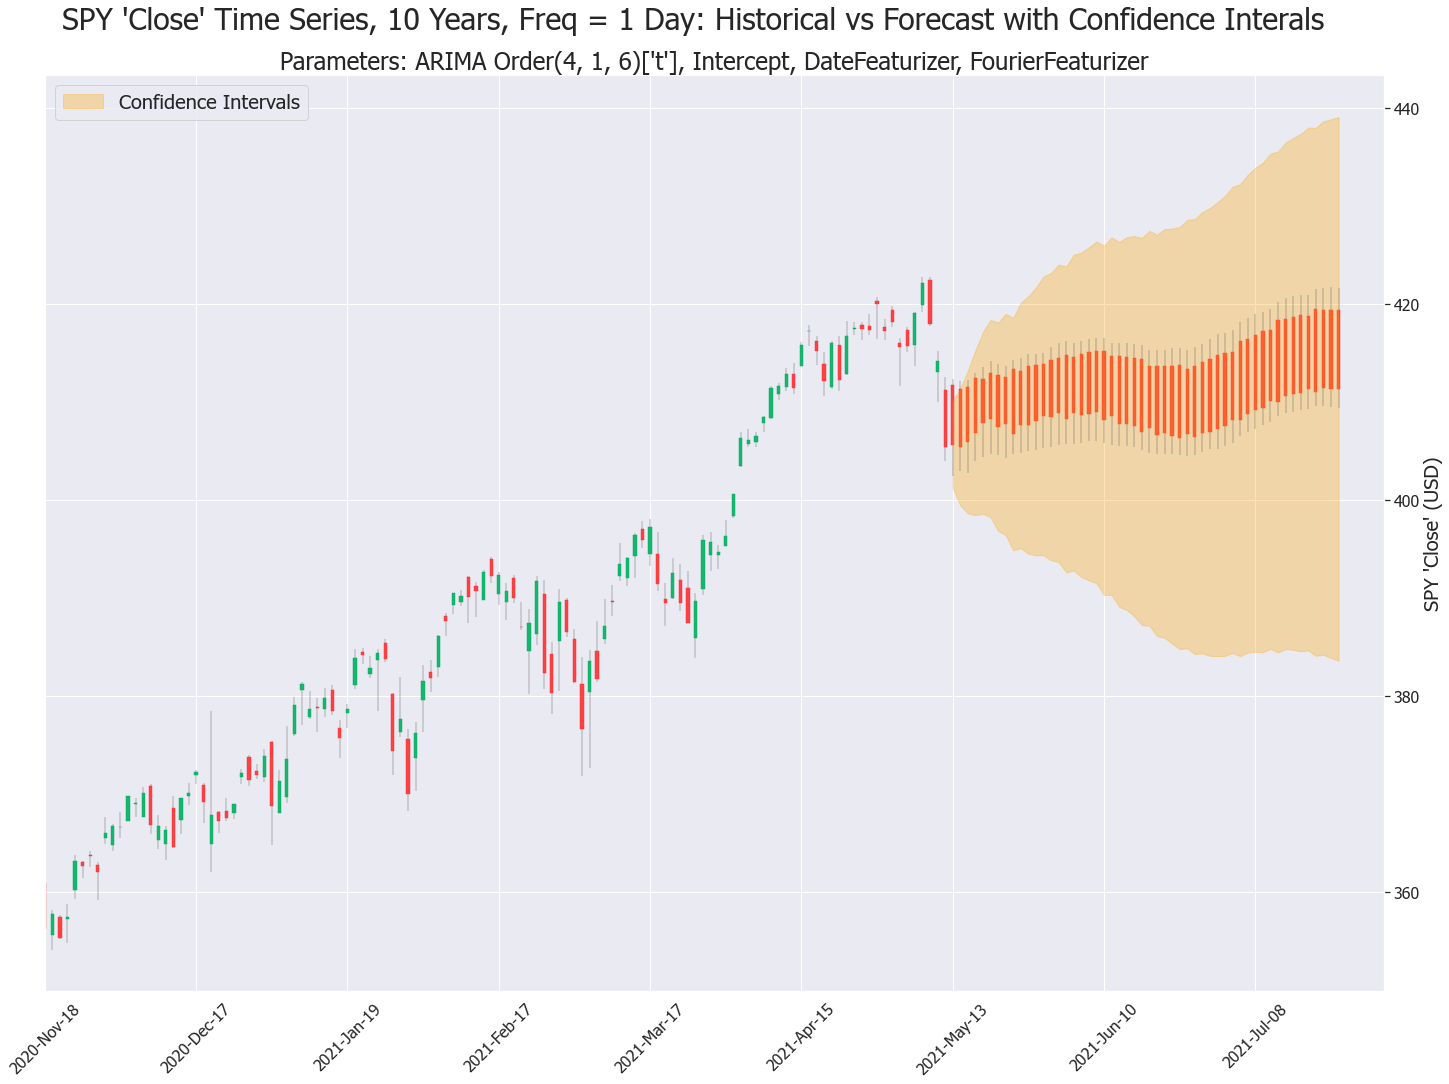

In [670]:
close_hat_df, close_hat, new_dates_df, close_conf_ints = pam_close.run_prediction(pam_close_best, 52, fin=True, all_ohlc=True,
                            exog_fc_df=exog_fc_df, exog_hist_df=exog_hist_df, en_ex='endo', ohlc_df=spy_df_10Y, ohlc_fc_df=ohlc_fc_df,
                            func='adhoc', verbose=1, visualize=True)

# Conclusion

Historical simulation was illuminating - we will need to research more trading strategies to take advantage of the flexibility of using a prediction. If we gather more data, especially on options, we should be able to further refine our model's accuracy.

At the least, our model performed better historically than inflation ([much better](https://www.bls.gov/data/inflation_calculator.htm)). Whether it would work in the real world remains to be seen. But certainly don't take our word for it. Really, don't, because this is not investment advice.

Any feedback, questions, suggestions, we are happy to discuss. Drop us a line:
wei.alex.xin@gmail.com